In [0]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn import metrics

from skimage import io, color

import time
import os
import pickle

import matplotlib.pyplot as plt
import scikitplot as skplt

In [0]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [0]:
# resnet152
pickle_in = open('history_resnet152.pkl', 'rb')
history_resnet152 = pickle.load(pickle_in)
pickle_in = open('history_resnet152_101.pkl', 'rb')
history_resnet152_101 = pickle.load(pickle_in)

# densenet161
pickle_in = open('history_densenet161.pkl', 'rb')
history_densenet161 = pickle.load(pickle_in)
pickle_in = open('history_densenet161_197.pkl', 'rb')
history_densenet161_197 = pickle.load(pickle_in)

#googlenet
pickle_in = open('history_gn21.pkl', 'rb')
history_googlenet = pickle.load(pickle_in)

#googlenet(3 classes)
pickle_in = open('history_3class1.pkl', 'rb')
history_googlenet3 = pickle.load(pickle_in)



# ResNet

In [0]:
res_train_loss = history_resnet152['train_loss'] + history_resnet152_101['train_loss']
res_valid_loss = history_resnet152['valid_loss'] + history_resnet152_101['valid_loss']
res_train_acc = history_resnet152['train_acc'] + history_resnet152_101['train_acc']
res_valid_acc = history_resnet152['valid_acc'] + history_resnet152_101['valid_acc']
res_valid_auc_score = history_resnet152['valid_auc_score'] + history_resnet152_101['valid_auc_score']

<Figure size 576x1440 with 0 Axes>

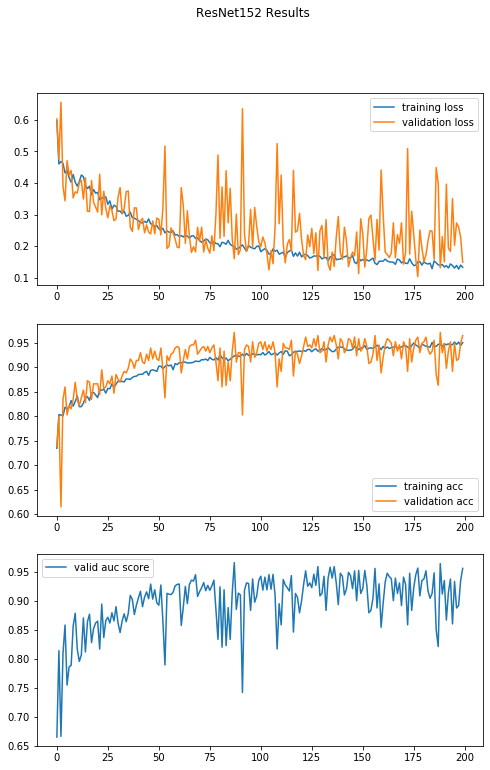

In [0]:
fig = plt.figure(figsize=(8, 20))

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,12))
fig.suptitle('ResNet152 Results')

ax1.plot(res_train_loss, label='training loss')
ax1.plot(res_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(res_train_acc, label='training acc')
ax2.plot(res_valid_acc, label='validation acc')
ax2.legend()

ax3.plot(res_valid_auc_score, label='valid auc score')
ax3.legend()

Epoch = 178 has the best results.

In [0]:
res_valid_acc[178-1], res_valid_auc_score[178-1]

(0.9617834394904459, 0.9563573883161512)

In [0]:
res_proabs_stacked = np.vstack(history_resnet152['valid_probas_list'])
res_true_labels = np.concatenate(history_resnet152['valid_truelabels_list'])
res_pred_labels = np.concatenate(history_resnet152['valid_preds_list'])

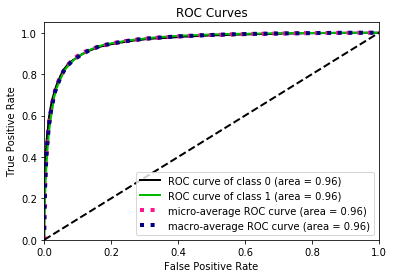

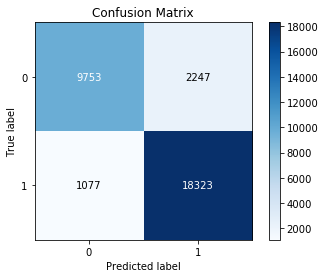

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc(res_true_labels, res_proabs_stacked)
skplt.metrics.plot_confusion_matrix(res_true_labels, res_pred_labels)

# DenseNet

In [0]:
den_train_loss = history_densenet161['train_loss'] + history_densenet161_197['train_loss']
den_valid_loss = history_densenet161['valid_loss'] + history_densenet161_197['valid_loss']
den_train_acc = history_densenet161['train_acc'] + history_densenet161_197['train_acc']
den_valid_acc = history_densenet161['valid_acc'] + history_densenet161_197['valid_acc']
den_valid_auc_score = history_densenet161['valid_auc_score'] + history_densenet161_197['valid_auc_score']

<Figure size 576x1440 with 0 Axes>

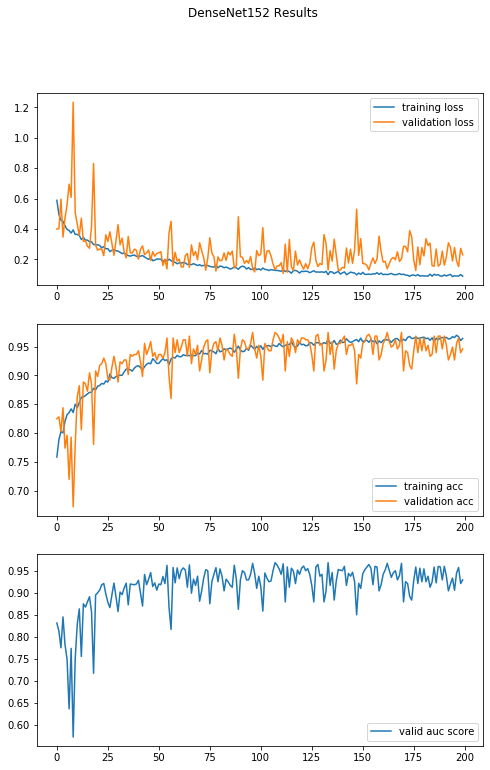

In [0]:
fig = plt.figure(figsize=(8, 20))

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,12))
fig.suptitle('DenseNet152 Results')

ax1.plot(den_train_loss, label='training loss')
ax1.plot(den_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(den_train_acc, label='training acc')
ax2.plot(den_valid_acc, label='validation acc')
ax2.legend()

ax3.plot(den_valid_auc_score, label='valid auc score')
ax3.legend()

Epoch = 198 has the best results.

In [0]:
den_valid_acc[198-1], den_valid_auc_score[198-1]

(0.964968152866242, 0.9573453608247423)

In [0]:
dense_proabs_stacked = np.vstack(history_densenet161['valid_probas_list'])
dense_true_labels = np.concatenate(history_densenet161['valid_truelabels_list'])
dense_pred_labels = np.concatenate(history_densenet161['valid_preds_list'])

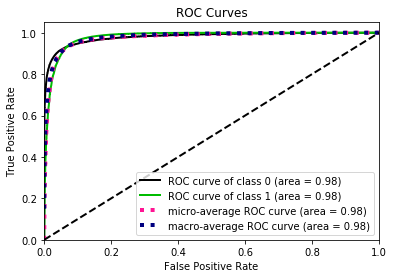

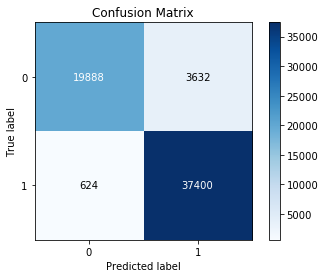

In [0]:
import scikitplot as skplt
skplt.metrics.plot_roc(dense_true_labels, dense_proabs_stacked)
skplt.metrics.plot_confusion_matrix(dense_true_labels, dense_pred_labels)

# GoogLeNet

In [0]:
goo_train_loss = history_googlenet['train_loss'] 
goo_valid_loss = history_googlenet['valid_loss'] 
goo_train_acc = history_googlenet['train_acc'] 
goo_valid_acc = history_googlenet['valid_acc'] 
goo_valid_auc_score = history_googlenet['valid_auc_score'] 

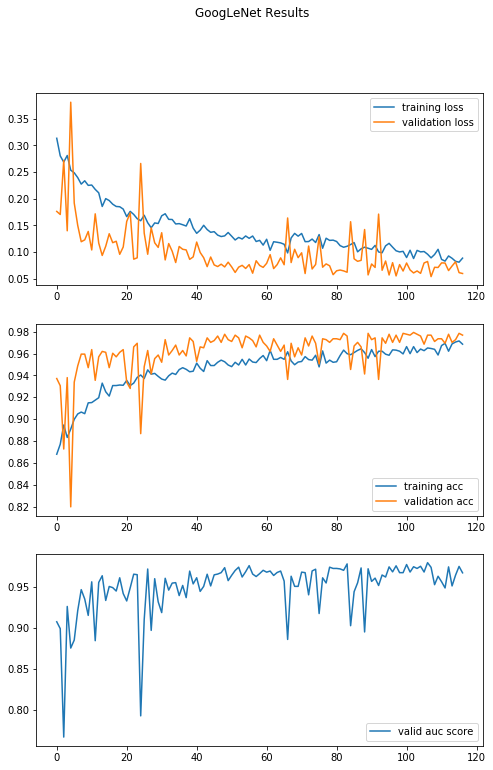

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,12))
fig.suptitle('GoogLeNet Results')

ax1.plot(goo_train_loss, label='training loss')
ax1.plot(goo_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(goo_train_acc, label='training acc')
ax2.plot(goo_valid_acc, label='validation acc')
ax2.legend()

ax3.plot(goo_valid_auc_score, label='valid auc score')
ax3.legend()

plt.savefig('GoogLeNet_train.jpeg')

In [0]:
print('Highest validation acc: ', max(goo_valid_acc), np.argmax(goo_valid_acc)+1)
print('Highest validation auc: ', max(goo_valid_auc_score), np.argmax(goo_valid_auc_score)+1)

Highest validation acc:  0.9793388429752066 103
Highest validation auc:  0.9793478673378209 107


## GoogLeNet(0: normal, 1: pneumonia) on validation set

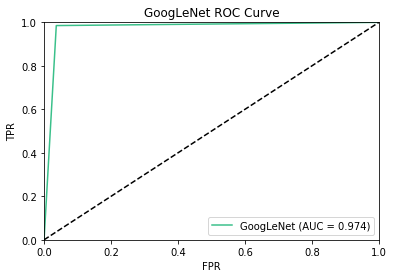

0.9743849383644587

In [0]:
preds, truths = pred_truth(model, valid_loader)
plotUnivariateROC(preds, truths, 'GoogLeNet', 'GoogLeNet ROC Curve')


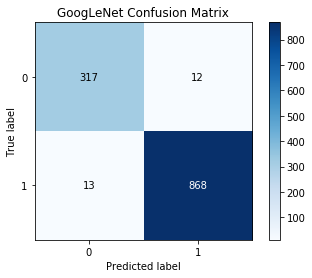

In [0]:
skplt.metrics.plot_confusion_matrix(true_labels, pred_labels, title = 'GoogLeNet Confusion Matrix')

# GoogLeNet(0: normal, 1: virus, 2: bacteria)

In [0]:
goo_train_loss = history_googlenet3['train_loss'] 
goo_valid_loss = history_googlenet3['valid_loss'] 
goo_train_acc = history_googlenet3['train_acc'] 
goo_valid_acc = history_googlenet3['valid_acc'] 

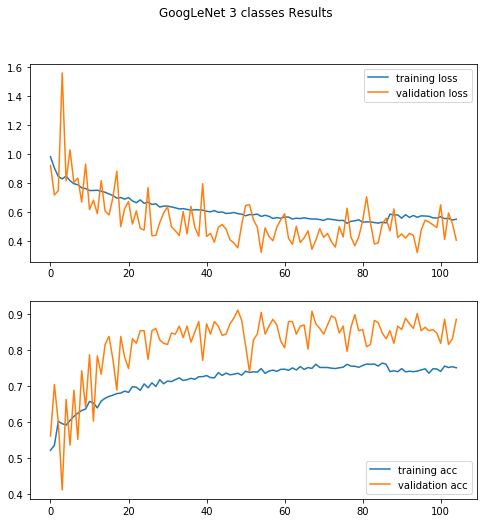

In [0]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
fig.suptitle('GoogLeNet 3 classes Results')

ax1.plot(goo_train_loss, label='training loss')
ax1.plot(goo_valid_loss, label='validation loss')
ax1.legend()

ax2.plot(goo_train_acc, label='training acc')
ax2.plot(goo_valid_acc, label='validation acc')
ax2.legend()

plt.savefig('GoogLeNet_3classestrain.jpeg')

## GoogLeNet(0: normal, 1: virus, 2: bacteria) on validation set

<ipython-input-19-02bc424a3bc6>:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
<ipython-input-19-02bc424a3bc6>:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
<ipython-input-20-8e390c3db6b2>:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


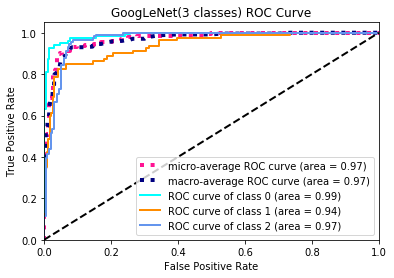

macro AUC for GoogLeNet is:  0.9669068808681136


In [0]:
y_s, y_t=inference(model,valid_loader)
r_AUC = get_AUC(y_s, y_t, True)
print('macro AUC for GoogLeNet is: ', r_AUC["macro"])

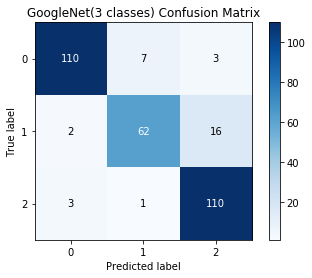

In [0]:
#val new
import scikitplot as skplt
#skplt.metrics.plot_roc(true_labels, proabs_stacked)
skplt.metrics.plot_confusion_matrix(true_labels, pred_labels, title = 'GoogleNet(3 classes) Confusion Matrix')